# Dataset

In [1]:
# stable diffusion 사용되는 모델들
# text-encoder와 text-tokenizer는 local 환경에 저장하고, 학습시에불러옵니다.

from PIL import Image
import torch
from torch import nn
import logging
import pandas as pd
from torch import nn,Tensor
import torch.nn.functional as F
import numpy as np
import os, json

from torch.utils.data import Dataset, DataLoader
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from diffusers import UniPCMultistepScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from transformers.optimization import AdamW

tokenizer = CLIPTokenizer.from_pretrained("/home/sangyeob/dev/d2d/5-K_stable_diffusion/tokenizer")
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")
scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")


/home/sangyeob/anaconda3/envs/ksd/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## tokenizer

encoder에 한국어 데이터를 학습시키고는 싶은데, 기존에 사용되는 cliptokenizer의 vocab을 보니 한국어가 없었습니다. clip vocab으로 한국어가 잘 tokenize 될 수 있는지를 확인하고, 없는 경우는 한국어가 추가된 tokenizer를 사용해야 했습니다.

In [2]:
tokenizer = CLIPTokenizer.from_pretrained("/home/sangyeob/dev/d2d/5-K_stable_diffusion/tokenizer")

In [3]:
text_e = 'hi, i\'m korean'
print(tokenizer.tokenize(text_e))
text_k = '안녕하세요'
print(tokenizer.tokenize(text_k))
text_k = '요세하녕안'
print(tokenizer.tokenize(text_k))
text_k = '안'
print(tokenizer.tokenize(text_k))
text_k = '녕'
print(tokenizer.tokenize(text_k))
text_k = '하'
print(tokenizer.tokenize(text_k))
text_k = '세'
print(tokenizer.tokenize(text_k))
text_k = '요'
print(tokenizer.tokenize(text_k))

text_j = 'おはよう'
print(tokenizer.tokenize(text_j))


['hi</w>', ',</w>', 'i</w>', "'m</w>", 'korean</w>']
['ìķ', 'Ī', 'ë', 'ħ', 'ķ', 'íķĺ', 'ìĦ', '¸', 'ìļ', 'Ķ</w>']
['ìļ', 'Ķ', 'ìĦ', '¸', 'íķĺ', 'ë', 'ħ', 'ķ', 'ìķ', 'Ī</w>']
['ìķ', 'Ī</w>']
['ë', 'ħ', 'ķ</w>']
['íķ', 'ĺ</w>']
['ìĦ', '¸</w>']
['ìļ', 'Ķ</w>']
['ãģ', 'Ĭãģ', '¯', 'ãĤ', 'Ī', 'ãģ', 'Ĩ</w>']


한국어 문장을 토큰화를 해보니, 영어처럼 형태소 단위로 토큰화를 하진 않지만 한글자씩 제대로 맵핑이 되고는 있는 것 같습니다. 어떤 원리로 저 글자들로 맵핑이 되는지는 몰라서 찜찜하지만 시간이 많지 않기 때문에, 또한 한국어 dataset을 추가적으로 학습한 clip model의 vocabs 를 봤는데도 한국어는 따로 존재하지 않았기 때문에 그냥 진행하기로 했습니다.

1) 일단 진행
2) 결과가 안나오면 한국어 tokenizer를 더 공부해서 추가. 

로 진행하기로 했습니다.

## Text Encoder

text_encoder 역시 허깅페이스 CompVis/stable-diffusion-v1-4의 pretrained ClipTextModel을 사용하지만 편의를 위해 local 환경에 저장해두고 불러왔습니다. ClipTextModel은 처음본 모델이기 때문에 어떤 구조로 되어 있는지 summary를 했습니다

In [4]:
text_encoder = CLIPTextModel.from_pretrained("/home/sangyeob/dev/d2d/5-K_stable_diffusion/text_encoder")

from torchinfo import summary
summary(text_encoder, input_size = (2, 77), dtypes=[torch.int], depth=4)

Layer (type:depth-idx)                                       Output Shape              Param #
CLIPTextModel                                                [2, 768]                  --
├─CLIPTextTransformer: 1-1                                   [2, 768]                  --
│    └─CLIPTextEmbeddings: 2-1                               [2, 77, 768]              --
│    │    └─Embedding: 3-1                                   [2, 77, 768]              37,945,344
│    │    └─Embedding: 3-2                                   [1, 77, 768]              59,136
│    └─CLIPEncoder: 2-2                                      [2, 77, 768]              --
│    │    └─ModuleList: 3-3                                  --                        --
│    │    │    └─CLIPEncoderLayer: 4-1                       [2, 77, 768]              7,087,872
│    │    │    └─CLIPEncoderLayer: 4-2                       [2, 77, 768]              7,087,872
│    │    │    └─CLIPEncoderLayer: 4-3                       [2, 77, 

기본적인 transformer encoder 구조인 것 같고, embedding 후의, attention layer가 여러개 있습니다. input size = (2, 77), output size = (batch_size, 77, 768)이고 77이 max_length, 768이 transformer의 hidden_dim 인 것 같습니다. Encoder layer가 12개나 되고 파라미터도 꽤나 많은 것으로 보아 학습시간이나 batch_size를 잘 조정해야 할 것 같습니다.

## loss

(영어 text, 한국어 text)를 입력으로 받고, tokenizer와 encoder를 지난 후에 각각의 embedding이 유사해지도록 학습을 할 계획입니다. 다만, 영어 text의 embedding이 많이 바뀌면 안되기 때문에 이에 대한 parameter를 추가합니다

최대한 학습전의 embedding을 해치지 않는 방향으로

$L = cos_similarity(text_e, text_k) + cos_similiar$


## Datasets



1. 한국어-영어 번역 말뭉치(기술과학) 
2. 텍스트 한국어-영어 번역 말뭉치(사회과학) 
3. 텍스트 한국어-영어 번역(병렬) 말뭉치
4. 방송콘텐츠 한국어-영어 번역 말뭉치

AI hub에서 4가지 한국어/영어 번역 데이터셋을 사용했습니다. 데이터가 너무커서 로컬 환경에서 데이터셋을 정리헀습니다.

총 4,893,326개의 이미지가 있었지만 약 25만개의 text pair만을 데이터로 사용하기로 했습니다.
그 이유는 한국말-모델 KoCLIP 에서는 약 82783개의 image와 텍스트를 사용했는데, 이 프로젝트에서는 image encoder 없이 text encoder만 학습을 시킬 것이기 때문에 좀 더 적은 데이터로도 가능할 것 같다고 생각했습니다.

In [2]:
data_dir = '/home/sangyeob/dev/d2d/5-K_stable_diffusion/dataset'   

data = []

for dir in sorted(os.listdir(data_dir)) : 
    if dir.startswith('.') or dir.endswith('ipynb'): continue
    filepath = data_dir + '/' + dir + '/data.json'
    
    
    with open(filepath, 'r') as f :
        js = json.loads(f.read())
        data += js
        
    print(f'{dir} : {len(js)}개')    
    
df = pd.DataFrame(data)
df

032.방송콘텐츠 한국어-영어 번역 말뭉치 : 587082개
한국어-영어 번역 말뭉치(기술과학) : 1344631개
한국어-영어 번역 말뭉치(사회과학) : 1361845개
한국어-영어 번역(병렬) 말뭉치 : 1602418개


,english,korea
0,I can't wait to do this.,빨리 해보고 싶어요.
1,You're gonna watch that with Korean subtitles.,당신은 저걸 한글자막과 함께 보게 될 거예요.
2,"So, you hear words.",그래서 단어들이 들립니다.
3,Football players do that 'goal'.,축구 선수들은 그것을 '골'이라고 합니다.
4,"Even the Spanish, hearing is so hard because s...",심지어 스페인인들도 한국어처럼 들리는 부분이 있어서 듣기가 아주 어렵습니다.
...,...,...
4895971,"Across from the Hilton Hotel, the path to Hoeh...",힐튼호텔 건너편에서 회현동주민센터로 내려가는 길에는 칙칙한 회색의 석축옹벽이 이어져...
4895972,There are a lot of people who are having a har...,힘든 분들이 많이 계시지만 조금이나마 어렵지 않도록 도움이 될 수 있도록 저희가 최...
4895973,It was possible to make the Republic of Korea ...,힘든 역사 속에서 대한민국을 불과 50여년 만에 빛나는 나라로 만들고 업적을 만들 ...
4895974,"As for doing hard work, most of all, they shou...",힘든 일을 하는 데는 무엇보다 정부가 큰 관심을 갖고 있다는 자부심을 갖도록 해야 한다.


Processing은 다음과 같이 진행합니다.

1. duplicates 삭제

2. null 값 삭제

3. 기존 stable diffusion의 max_length인 77을 넘어가는 텍스트들 삭제

In [3]:
#1 duplicate 삭제
x = df.sample(1200000)
x = x.drop_duplicates()
print(f"중복된 데이터를 제거한 데이터셋 개수 : {len(x)}")

#2 null 값 삭제
x_null = x.isnull()
print(f"영어 텍스트 null 개수: {len(x_null.loc[x_null['english'] == True])}")
print(f"한국어 텍스트 null 개수: {len(x_null.loc[x_null['korea'] == True])}")
x  = x.dropna(axis=0, how='any')
print(f"null값을 제거한 데이터셋 개수 : {len(x)}")

#3 10만개 sampling 후, max length 초과 텍스트들 제거제거
# x_sampled = x.sample(100000)

x['eng_tokenized'] = x['english'].apply(lambda x : len(tokenizer(x).input_ids) <= 77)
x['kor_tokenized'] = x['korea'].apply(lambda x : len(tokenizer(x).input_ids) <= 77)
x = x[x['eng_tokenized'] & x['kor_tokenized']]
x

중복된 데이터를 제거한 데이터셋 개수 : 1199839
영어 텍스트 null 개수: 0
한국어 텍스트 null 개수: 0


Token indices sequence length is longer than the specified maximum sequence length for this model (85 > 77). Running this sequence through the model will result in indexing errors


null값을 제거한 데이터셋 개수 : 1199839


,english,korea,eng_tokenized,kor_tokenized
2290303,Students generally perceived art as one of sev...,학생들은 대체로 예술을상담에 활용할 여러 도구 중의 하나로 인지하고 있었다.,True,True
2562471,"When I was in my third year, I changed my cour...",3학년 때 현대사회로 과정을 변경하여 과목을 이수하였다.,True,True
3360518,My goal is to buy a hamburger from a developer.,내 목표는 개발자로부터 햄버거를 사는 것입니다.,True,True
125083,Thankful Won-suk jokes.,고마운 원숙이 농담을 한다.,True,True
3670847,Have you made many Japanese friends?,당신 일본 친구들은 많이 사귀었나요?,True,True
...,...,...,...,...
3590151,My words and actions are usually on the polite...,평소에 내 말과 행동은 공손한 편입니다.,True,True
1281445,A plurality of containers 361 may be provided ...,상기 승강장치(80)에는 복수의 용기(361)가 구비될 수 있다.,True,True
1118325,"Whenever the pH of the solvent was 0.7, separa...",용매의 pH가 0.7일 때는 따로 생성된 실리카 입자들을 관찰할 수 없었다.,True,True
139005,"First of all, according to records, King Sejo ...",일단은 기록에 따르면 세조가 그때 많이 아팠다고 해요.,True,True


In [4]:
df_100000 = x
df_100000.to_csv('/home/sangyeob/dev/d2d/5-K_stable_diffusion/df_500000.csv', index = False)

In [3]:
df_100000 = pd.read_csv('/home/sangyeob/dev/d2d/5-K_stable_diffusion/df_100000.csv')
df_100000

df_100000['eng_tokenized'] = df_100000['english'].apply(lambda x : tokenizer(x, padding="max_length", max_length=77, truncation=True, return_tensors='pt').input_ids)

In [4]:
text_encoder = CLIPTextModel.from_pretrained("/home/sangyeob/dev/d2d/5-K_stable_diffusion/text_encoder")
text_encoder.to('cuda')

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

In [3]:
class EnKoDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=77):
        self.text_e = tokenizer(list(df['english']), padding="max_length", max_length=max_length, truncation=True, return_tensors='pt').input_ids
        self.text_k = tokenizer(list(df['korea']), padding="max_length", max_length=max_length, truncation=True, return_tensors='pt').input_ids
        
    def __len__(self):
        return len(self.text_e)

    def __getitem__(self, idx):
        return self.text_e[idx], self.text_k[idx]

def dataset_split(dataset, ratio):
    train_size = int(ratio * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    return train_dataset, val_dataset


## Training

clip training code와 과제4 학습코드를 참고하여 작성하였습니다. (https://github.com/Bing-su/train_ml_clip) 


input으로 받은 영어텍스트와 한국어 텍스트를 각각 ClipEncoder에 넣어주고, 결과로 나온 두개의 임베딩이 비슷해지도록 학습을 해볼 예정입니다.

영어 텍스트와 한국어 텍스트는 같은 의미의 문장이므로, 두 임베딩은 유사한 의미를 가져야합니다. 이를 어떻게 표현할 수 있을까 많은 고민을 해봤는데, 

1. cosine similarity : 두 임베딩 벡터 간의 cosine similarity 구합니다. 의미가 유사할수록 높은 값을 가져야 합니다.

2. Mean Squared Error : 두 임베딩 벡터 간의 수치가 비슷해지도록 학습이 됩니다.


embedding(text_e)와 embedding(text_k)와의 cosine similarity를 loss로 줍니다.

하지만, 학습과정에서 영어 텍스트에 대한 embedding이 너무 많이 변해버리면 이후의 unet에 text_embedding으로 들어갈때 이미지 결과가 크게 변할 수도 있기 때문에 이 너무 많은 값이 변하지 않기 위한 정규화 파라미터 또는 mse를 넣어줄 것입니다.

우선 

In [8]:
text_encoder = CLIPTextModel.from_pretrained("/home/sangyeob/dev/d2d/5-K_stable_diffusion/text_encoder")

In [18]:
text_1 = 'we are all precious.'
text_2 = '우리는 모두 소중한 존재입니다.'


text_e1 = tokenizer(text_1, padding="max_length", max_length=77, truncation=True, return_tensors='pt').input_ids
text_e2 = tokenizer(text_2, padding="max_length", max_length=77, truncation=True, return_tensors='pt').input_ids
text_k1 = tokenizer("고양이와 개", padding="max_length", max_length=77, truncation=True, return_tensors='pt').input_ids

print(text_e1.shape)
v1 = text_encoder(input_ids = text_e1)[0]
v2 = text_encoder(input_ids = text_e2)[0]
v3 = text_encoder(input_ids = text_k1)[0]


mse_loss = nn.MSELoss()
print(v1.shape)
print(mse_loss(v1, v2))
print(mse_loss(v1, v3))
print(mse_loss(v2, v3))

cos_loss = nn.CosineEmbeddingLoss()
print(cos_loss(v1.reshape(1, -1), v2.reshape(1, -1), target= torch.ones(1)))
print(cos_loss(v1.reshape(1, -1), v3.reshape(1, -1), target= torch.ones(1)))
print(cos_loss(v2.reshape(1, -1), v3.reshape(1, -1), target= torch.ones(1)))

# 한국말끼리는 cos simmilarity가 높은 모양

torch.Size([1, 77])
torch.Size([1, 77, 768])
tensor(1.5193, grad_fn=<MseLossBackward0>)
tensor(1.4839, grad_fn=<MseLossBackward0>)
tensor(0.7806, grad_fn=<MseLossBackward0>)
tensor(0.7145, grad_fn=<MeanBackward0>)
tensor(0.6916, grad_fn=<MeanBackward0>)
tensor(0.3616, grad_fn=<MeanBackward0>)


In [1]:
import torch
import torch.nn.functional as F
import logging
import pandas as pd
from PIL import Image
from torch import nn,Tensor
import numpy as np
import os, json
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPTextModel, CLIPTokenizer
from transformers.optimization import AdamW, get_cosine_schedule_with_warmup
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

class EnKoDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=77):
        self.text_e = tokenizer(list(df['english']), padding="max_length", max_length=max_length, truncation=True, return_tensors='pt').input_ids
        self.text_k = tokenizer(list(df['korea']), padding="max_length", max_length=max_length, truncation=True, return_tensors='pt').input_ids
        
    def __len__(self):
        return len(self.text_e)

    def __getitem__(self, idx):
        return self.text_e[idx], self.text_k[idx]

def dataset_split(dataset, ratio):
    train_size = int(ratio * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    return train_dataset, val_dataset



def _validate(model, dev_dataloader, device, logger, global_step, loss_type, initial_embed_e_val):
    
    loss_fn_mse = nn.MSELoss()
    loss_fn_cos = nn.CosineEmbeddingLoss()
    loss_list = []
    
    model.eval() 
    
    for step_index, batch_data in tqdm(enumerate(dev_dataloader), f"[Eval] Valid\t", total=len(dev_dataloader)):
        with torch.no_grad():
            text_e, text_k = batch_data
            batch_size = text_e.shape[0]
            
            texts = torch.cat((text_e, text_k), dim=0).to('cuda')
            embeds = model(texts)[0]
            embed_e, embed_k = embeds[:batch_size], embeds[batch_size:]
        
            if loss_type == "mse" : 
                loss = loss_fn_mse(embed_e, embed_k) 
                loss += loss_fn_mse(embed_e, initial_embed_e_val[step_index, :batch_size]) 
                loss += loss_fn_mse(embed_k, initial_embed_e_val[step_index, :batch_size])
            elif loss_type == "cos" : 
                loss = loss_fn_cos(embed_e.reshape(batch_size, -1), embed_k.reshape(batch_size, -1), torch.ones(batch_size).to(device))
                loss += loss_fn_cos(embed_e.reshape(batch_size, -1), initial_embed_e_val[step_index, :batch_size].reshape(batch_size, -1), torch.ones(batch_size).to(device))
                loss += loss_fn_cos(embed_k.reshape(batch_size, -1), initial_embed_e_val[step_index, :batch_size].reshape(batch_size, -1), torch.ones(batch_size).to(device))
                
            loss_value = loss.cpu().clone().detach().numpy()
            loss_list.append(loss_value)

    mean_loss = np.mean(loss_list)
    model.train()

    return mean_loss


def train(model, optimizer, scheduler, train_dataloader, val_dataloader, device, loss_type, batch_size, max_length, hidden_dim):
    
    model.to(device)  
    model.train() 
    
    loss_list_between_log_interval = []
    loss_fn_mse = nn.MSELoss()
    loss_fn_cos = nn.CosineEmbeddingLoss()
    
    initial_embed_e = torch.zeros((step_per_epoch, batch_size, max_length, hidden_dim), device = device)
    initial_embed_e_val = torch.zeros((step_per_epoch_val, batch_size, max_length, hidden_dim), device = device)
    loss_value = 0
    
    logger.info('\tinit validation dataset..start')
    
    for step_index, batch_data in tqdm(enumerate(val_dataloader), f"[Eval] Valid\t", total=len(val_dataloader)) : 
        with torch.no_grad():
            text_e, _ = batch_data
            embed_e = model(text_e.to(device))[0]
            initial_embed_e_val[step_index, :embed_e.shape[0]] = embed_e.clone().detach()
    
    logger.info('\tinit validation dataset..end')
    
    for epoch_id in range(epochs):             
        for step_index, batch_data in tqdm(enumerate(train_dataloader), f"[TRAIN] Epoch_{epoch_id}\t", total=len(train_dataloader)):
            
            global_step = len(train_dataloader) * epoch_id + step_index + 1
            optimizer.zero_grad()

            text_e, text_k = batch_data
            batch_size = text_e.shape[0]
            
            texts = torch.cat((text_e, text_k), dim=0).to('cuda')
            embeds = model(texts)[0]
            embed_e, embed_k = embeds[:batch_size], embeds[batch_size:]
            
            if epoch_id == 0 : initial_embed_e[step_index,:batch_size] = embed_e.clone().detach()
                
            if loss_type == "mse" : 
                loss = loss_fn_mse(embed_e, embed_k) + loss_fn_mse(embed_e, initial_embed_e[step_index,:batch_size]) + loss_fn_mse(embed_k, initial_embed_e[step_index,:batch_size])
            elif loss_type == "cos" : 
                loss = loss_fn_cos(embed_e.reshape(batch_size, -1), embed_k.reshape(batch_size, -1), torch.ones(batch_size).to(device))
                loss += loss_fn_cos(embed_e.reshape(batch_size, -1), initial_embed_e[step_index,:batch_size].reshape(batch_size, -1), torch.ones(batch_size).to(device))
                loss += loss_fn_cos(embed_k.reshape(batch_size, -1), initial_embed_e[step_index,:batch_size].reshape(batch_size, -1), torch.ones(batch_size).to(device))
            
            loss.backward()
            loss_value = loss.cpu().clone().detach().numpy()
            loss_list_between_log_interval.append(loss_value)
            
            # torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()
            scheduler.step()

        mean_loss = np.mean(loss_list_between_log_interval)
        loss_list_between_log_interval.clear()
        
        logger.info(f"\ttrain_epoch:{epoch_id}\t global_step:{global_step} loss:{mean_loss:.4f}")
        
        val_loss = _validate(model, val_dataloader, device, logger, global_step, loss_type, initial_embed_e_val)
        logger.info(f"\tvalidation\t global_step:{global_step} loss:{val_loss:.4f}")

    # 모델 저장 코드
    state_dict = model.state_dict()
    model_path = os.path.join('/home/sangyeob/dev/d2d/5-K_stable_diffusion', f"k-clip_encoder_{loss_type}.pth")
    torch.save(state_dict, model_path)
    logger.info(
        f"saved at {model_path}"
    )

    return model

/home/sangyeob/anaconda3/envs/ksd/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tokenizer = CLIPTokenizer.from_pretrained("/home/sangyeob/dev/d2d/5-K_stable_diffusion/tokenizer")
text_encoder = CLIPTextModel.from_pretrained("/home/sangyeob/dev/d2d/5-K_stable_diffusion/text_encoder")
df_100000 = pd.read_csv('/home/sangyeob/dev/d2d/5-K_stable_diffusion/df_100000.csv')

batch_size = 8 
dataset_df = df_100000.sample(1000)

logger = logging.getLogger()  
logger.setLevel(logging.INFO)  

logging.info("\tdataset loading..")
start_time = time.time()
dataset = EnKoDataset(dataset_df, tokenizer)
train_dataset, val_dataset = dataset_split(dataset, 0.8)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
logging.info(f"\tdataset loaded.. {(time.time() - start_time):.2f} passed")

# Config
epochs = 10  
learning_rate = 1e-6
weight_decay = 1e-4
save_interval = 1000 
grad_clip = 1.0
batch_size = 16

# optimizer
param_optimizer = list(text_encoder.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(
        nd in n for nd in no_decay)], 'weight_decay': weight_decay},
    {'params': [p for n, p in param_optimizer if any(
        nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, correct_bias=False)

# scheduler
step_per_epoch = len(train_dataloader)
num_total_steps = step_per_epoch * epochs

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    learning_rate,
    total_steps=num_total_steps
)

# scheduler = get_cosine_schedule_with_warmup(
#     optimizer, 
#     num_warmup_steps = num_total_steps * 0.1, 
#     num_training_steps = num_total_steps
# )

step_per_epoch = len(train_dataloader)
step_per_epoch_val = len(val_dataloader)
total_train_dataset_len = len(train_dataset)
total_valid_dataset_len = len(val_dataset)
num_total_steps = step_per_epoch * epochs

INFO:root:	dataset loading..
INFO:root:	dataset loaded.. 0.62 passed
/home/sangyeob/anaconda3/envs/ksd/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
logging.info(f'\tstep_per_epoch : {step_per_epoch}')
logging.info(f'\tstep_per_epoch_val : {step_per_epoch_val}')
logging.info(f'\ttotal_dataset_len : {total_train_dataset_len} + {total_valid_dataset_len} = {total_train_dataset_len + total_valid_dataset_len}')
logging.info(f'\tnum_total_steps : {num_total_steps}')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

text_encoder = train(model=text_encoder, 
                    optimizer=optimizer, 
                    scheduler=scheduler, 
                    train_dataloader=train_dataloader, 
                    val_dataloader=val_dataloader, 
                    device=device, 
                    loss_type="mse", 
                    batch_size=32, 
                    max_length=77, 
                    hidden_dim=768)

In [2]:
from transformers import CLIPTextModel, CLIPTokenizer

tokenizer = CLIPTokenizer.from_pretrained("/home/sangyeob/dev/d2d/5-K_stable_diffusion/tokenizer")

text_encoder_1 = CLIPTextModel.from_pretrained("/home/sangyeob/dev/d2d/5-K_stable_diffusion/text_encoder")
text_encoder_2 = CLIPTextModel.from_pretrained("/home/sangyeob/dev/d2d/5-K_stable_diffusion/text_encoder/1/encoder_5e-7_10000")

text_encoder_1.eval()
text_encoder_2.eval()

with torch.no_grad() : 
    
    text_e = 'dog painted by pen'
    text_k = '펜으로 그린 강아지'
    token_e = tokenizer(text_e, padding="max_length", max_length=77, truncation=True, return_tensors='pt').input_ids
    token_k = tokenizer(text_k, padding="max_length", max_length=77, truncation=True, return_tensors='pt').input_ids

    init_embed_e = text_encoder_1(input_ids = token_e)[0]
    init_embed_k = text_encoder_1(input_ids = token_k)[0]
    
    mse_loss = nn.MSELoss()
    cos_loss = nn.CosineEmbeddingLoss()
    
    embed_e = text_encoder_2(input_ids = token_e)[0]
    embed_k = text_encoder_2(input_ids = token_k)[0]
    
    print(f'학습 전 영어, 한국어 간 mse_loss : {mse_loss(init_embed_e, init_embed_k)}')
    print(f'학습 후 영어, 한국어 간 mse_loss : {mse_loss(embed_e, embed_k)}')
    print(f'원래 임베딩과 영어 텍스트 간 mse_loss : {mse_loss(embed_e, init_embed_e)}')
    print(f'원래 임베딩과 한국어 텍스트 간 mse_loss : {mse_loss(embed_k, init_embed_e)}')
    print(f'전체 mse_loss : {mse_loss(embed_e, embed_k) + mse_loss(embed_e, init_embed_e) + mse_loss(embed_k, init_embed_e)}\n')

    init_embed_e = init_embed_e.reshape(1, -1)
    init_embed_k = init_embed_k.reshape(1, -1)
    embed_e = embed_e.reshape(1, -1)
    embed_k = embed_k.reshape(1, -1)
    target = torch.ones(1)
    
    print(f'학습 전 영어, 한국어 간 cos_loss : {cos_loss(init_embed_e, init_embed_k, target)}')
    print(f'학습 후 영어, 한국어 간 cos_loss : {cos_loss(embed_e, embed_k, target)}')
    print(f'원래 임베딩과 영어 텍스트 간 cos_loss : {cos_loss(embed_e, init_embed_e, target)}')
    print(f'원래 임베딩과 한국어 텍스트 간 cos_loss : {cos_loss(embed_k, init_embed_e, target)}')
    print(f'전체 cos_loss : {cos_loss(embed_e, embed_k, target) + cos_loss(embed_e, init_embed_e, target) + cos_loss(embed_k, init_embed_e, target)}')
    
# 한국말끼리는 cos simmilarity가 높은 모양
    

학습 전 영어, 한국어 간 mse_loss : 1.502813696861267
학습 후 영어, 한국어 간 mse_loss : 0.3236461281776428
원래 임베딩과 영어 텍스트 간 mse_loss : 0.3596910834312439
원래 임베딩과 한국어 텍스트 간 mse_loss : 1.0708229541778564
전체 mse_loss : 1.7541601657867432

학습 전 영어, 한국어 간 cos_loss : 0.7046377658843994
학습 후 영어, 한국어 간 cos_loss : 0.17061156034469604
원래 임베딩과 영어 텍스트 간 cos_loss : 0.1767714023590088
원래 임베딩과 한국어 텍스트 간 cos_loss : 0.5344890356063843
전체 cos_loss : 0.8818719983100891


In [5]:
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from diffusers import UniPCMultistepScheduler
from transformers import CLIPTextModel, CLIPTokenizer

text_encoder = CLIPTextModel.from_pretrained("/home/sangyeob/dev/d2d/5-K_stable_diffusion/text_encoder/1/encoder_5e-7_10000")
tokenizer = CLIPTokenizer.from_pretrained("/home/sangyeob/dev/d2d/5-K_stable_diffusion/tokenizer")

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")
scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

In [6]:
n_vae = sum(p.numel() for p in vae.parameters() if p.requires_grad)
n_text_encoder = sum(p.numel() for p in text_encoder.parameters() if p.requires_grad)
n_unet = sum(p.numel() for p in unet.parameters() if p.requires_grad)
n_total = n_vae + n_text_encoder + n_unet

n_vae = format(n_vae, ',')
n_text_encoder = format(n_text_encoder, ',')
n_unet = format(n_unet, ',')
n_total = format(n_total, ',')

print(f'vae : {n_vae}')
print(f'text_encoder : {n_text_encoder}')
print(f'unet : {n_unet}')
print(f'total : {n_total}')

vae : 83,653,863
text_encoder : 123,060,480
unet : 859,520,964
total : 1,066,235,307


In [7]:
torch_device = "cuda"
unet.to(torch_device)
text_encoder.to(torch_device)
vae.to(torch_device)

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, ep

In [17]:
# input 준비
text = ["yellow car in front of brick house", "강아지"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 25  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.manual_seed(0)  # Seed generator to create the inital latent noise
batch_size = len(text)

In [18]:
text_input = tokenizer(
    text, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

print(text_input.input_ids.shape)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
    # text_embeddings = text_encoder(text_input.input_ids.to(torch_device), text_input.attention_mask.to(torch_device))[0]

max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

print(text_embeddings.shape, latents.shape)


torch.Size([2, 77])
torch.Size([4, 77, 768]) torch.Size([2, 4, 64, 64])


/tmp/ipykernel_34520/3239879329.py:18: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


In [19]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample



100%|██████████| 25/25 [00:14<00:00,  1.76it/s]


In [15]:
print(latents.shape)

torch.Size([2, 4, 64, 64])


<class 'torch.Tensor'>


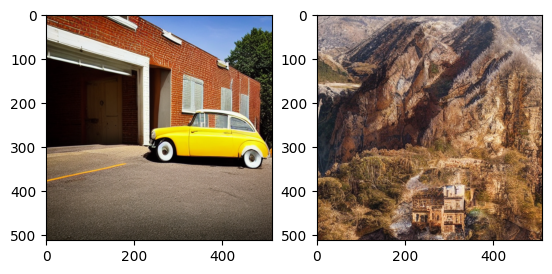

In [20]:
latents = 1 / 0.18215 * latents

with torch.no_grad():
    image = vae.decode(latents).sample

print(type(image))
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(pil_images[0])
ax[1].imshow(pil_images[1])

<class 'torch.Tensor'>


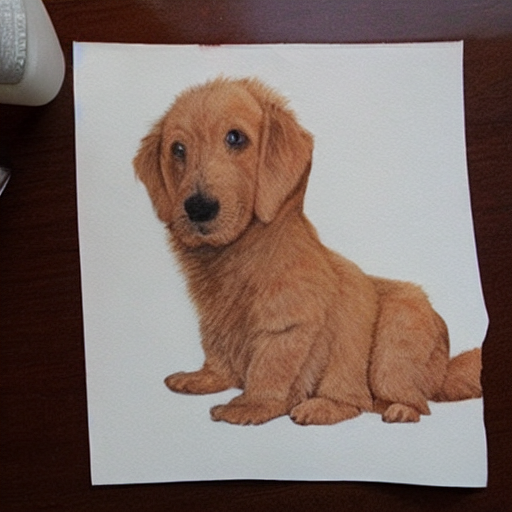

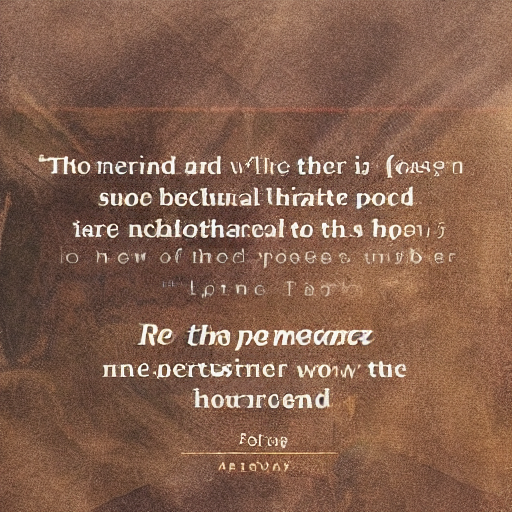

In [21]:
latents = 1 / 0.18215 * latents

with torch.no_grad():
    image = vae.decode(latents).sample

print(type(image))
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(pil_images[0])
ax[1].imshow(pil_images[1])

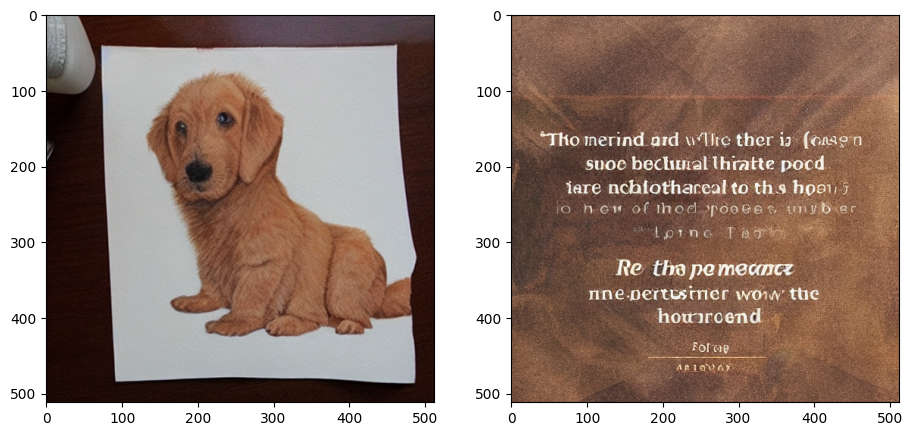